<a href="https://colab.research.google.com/github/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/Project_3_Natural_Language_Processing_with_Reddit_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id = 'section_0'><a/>
# 0.0 Function Creation
___

In [182]:
import time
from time import sleep
import requests

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve

pd.set_option('display.max_colwidth' , 300)

In [30]:
def red_scrap(title):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df_load = []
    params = {
        'subreddit': title,
        'size' : 100,
        'before': None
    }
    for i in range(15):
        # Access Reddit API
        res = requests.get(url,params)
        data = res.json()
        posts = data['data']
        
        
        df_new = pd.DataFrame(posts)
        df_load.append(df_new)
        
        # Initiating new time stamp (100th position of the 100 size) for before in params
        params['before'] = df_new['created_utc'][99]
        
        # Extract to CSV
        df = pd.concat(df_load, ignore_index = True)
        df.to_csv(f'{title}.csv')
        time.sleep(10)
        print(f'{i+1} Iterations completed')
        
    return df

In [3]:
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [4]:
def eval_classification(y_true , y_pred):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)

    score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

    return score_dict

In [ ]:
df_fakenews = red_scrap('fakenews')

In [ ]:
df_worldnews = red_scrap('worldnews')

<a id = 'section_1'><a/>
# 1.0 Data Exploration
___
[(back to top)](#content)

In [102]:
# Fake News Reddit
df_fakenews = pd.read_csv('/content/fakenews.csv')
df_fakenews = df_fakenews[['title' , 'subreddit' , 'created_utc']]
df_fakenews = date_conversion(df_fakenews , 'created_utc')

# World News Reddit
df_worldnews = pd.read_csv('/content/worldnews.csv')
df_worldnews = df_worldnews[['title' , 'subreddit' , 'created_utc']]
df_worldnews = date_conversion(df_worldnews , 'created_utc')

In [103]:
print(f'No. of Fakenews Datasets : {len(df_fakenews)}')
print(f'Shape of Fakenews Datasets : {df_fakenews.shape}')

print(f'No. of World News Datasets : {len(df_worldnews)}')
print(f'Shape of World News Datasets : {df_worldnews.shape}')

No. of Fakenews Datasets : 1500
Shape of Fakenews Datasets : (1500, 3)
No. of World News Datasets : 1100
Shape of World News Datasets : (1100, 3)


### 1.1 Checking for Duplicates and Null
___

In [94]:
print(f'No. of Duplicate Cell : {df_fakenews.duplicated().sum()}')
print(f'No. of Null Cell : {df_fakenews.isnull().sum().sum()}')
df_fakenews.drop_duplicates(inplace = True)

No. of Duplicate Cell : 1
No. of Null Cell : 0


In [95]:
print(f'No. of Duplicate Cell : {df_worldnews.duplicated().sum()}')
print(f'No. of Null Cell : {df_worldnews.isnull().sum().sum()}')

No. of Duplicate Cell : 0
No. of Null Cell : 0


### 1.2 Visualing Some Random Text
___

In [96]:
# Visualing Some Random Post from Fake News
random_sentences = random.sample(df_fakenews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 MILITARY INTELIGENCE HAS EXPOSED THE OPERATION TO TAKE OVER THE UNITED STATES GREAT INFORMATION
1 BLAME TRUMP
2 Orange Man bad. TDS on display.
3 Everything You Need to Know about Fake News: How to Spot Fake News
4 From what I have seen this is not the Tulsa rally but can not confirm.. is this real?
5 'Harambe: The Musical' is Heading To Broadway
6 Google and Twitter Approved Our BS Anti-Vaxx Ads
7 You can now barbecue up to 6 friends
8 Hard to Tell if this is From CNBC or The Onion!
9 ADHD DOES NOT EXIST


In [97]:
# Visualing Some Random Post from World News
random_sentences = random.sample(df_worldnews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 Upside-down rhino research wins Ig Nobel Prize
1 BRICS summit: Putin blasts US over Afghanistan 'crisis'
2 How mass killings by US forces after 9/11 boosted support for the Taliban
3 Prince Andrew 'served with papers' over bombshell sex assault allegations
4 Unbelievable!! Apocalypse of Stones in Canada! 🚨 Hailstorm struck Regina...
5 Thalaivii, Bhoot Police movie review and release LIVE UPDATES: When and where to watch Saif Ali Khan, Arjun Kapoor film : trendienewz
6 Tigrayan rebels kill hundreds of Amhara civilians in Ethiopia
7 Lukashenko may Concede to a Union with Russia and a Undercut of Belarus Sovereignty
8 How A Bunch Of Men Came Up With The Texas Abortion Law That May Overturn Roe
9 True global Covid death toll ‘may be more than 15 million’


# 2.0 Data Cleaning and Preprocessing
___

In [98]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

port_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.1 TextVectorizer Input and Visualize Random Sentence
___

In [99]:
'''
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
'''
random_sentences = random.sample(df_fakenews['title'].to_list() , 3)

for sentence in random_sentences:
    
    # Print Before Split
    print('Original Sentence                : ' , sentence)

    # Remove Numeric Number , lower words
    regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
    sent_split = regex_token.tokenize(sentence.lower())
    print('Remove Numeric , lowercase       : ' , sent_split)
    
    # Stripped the Punctuation
    sent_split = [word for word in sent_split if word not in (string.punctuation)]
    print('Remove Punctuation               : ' , sent_split)

    # Remove Stop words
    sent_split = [word for word in sent_split if word not in (stop_words)]
    print('Remove Stop words                : ' , sent_split)

    # Stem the words and joint back  
    joint = ' '.join([port_stemmer.stem(word) for word in sent_split])
    print('Stem the words & joint the words : ' , joint)
    print('-----------------------------------------')
    

Original Sentence                :  BREAKING NEWS: Rapper Tekashi 69 Has Died Of Apparent LIGMA Overdose He Was Only 22
Remove Numeric , lowercase       :  ['breaking', 'news', 'rapper', 'tekashi', 'has', 'died', 'of', 'apparent', 'ligma', 'overdose', 'he', 'was', 'only']
Remove Punctuation               :  ['breaking', 'news', 'rapper', 'tekashi', 'has', 'died', 'of', 'apparent', 'ligma', 'overdose', 'he', 'was', 'only']
Remove Stop words                :  ['breaking', 'news', 'rapper', 'tekashi', 'died', 'apparent', 'ligma', 'overdose']
Stem the words & joint the words :  break news rapper tekashi die appar ligma overdos
-----------------------------------------
Original Sentence                :  NYT CAUGHT Reporting Egregious Errors On Coronavirus
Remove Numeric , lowercase       :  ['nyt', 'caught', 'reporting', 'egregious', 'errors', 'on', 'coronavirus']
Remove Punctuation               :  ['nyt', 'caught', 'reporting', 'egregious', 'errors', 'on', 'coronavirus']
Remove Stop word

### 2.2 Preprocess Function for data
___

In [108]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [ ]:
preprocessing(df_fakenews , 'title')

In [111]:
df_fakenews.head()

,title,subreddit,created_utc
0,research show great awoken media preced trump outlast opinion,fakenews,2021-09-11 13:37:46
1,get paid china stir panic,fakenews,2021-09-10 18:52:00
2,fact check journalist spread misinform wi spa,fakenews,2021-09-10 16:25:26
3,afghani central bank governor imag goe viral real asia market,fakenews,2021-09-10 13:48:40
4,stori mike emm real,fakenews,2021-09-08 21:29:04


In [110]:
preprocessing(df_worldnews , 'title')

In [112]:
df_worldnews.head()

,title,subreddit,created_utc
0,almost leather pant weather,worldnews,2021-09-11 16:24:35
1,googl underpaid thousand intern shadow worker violat labor law around world report reveal,worldnews,2021-09-11 16:20:01
2,nên vệ sinh nhà cửa bao lâu một lần,worldnews,2021-09-11 16:18:02
3,afghanistan taliban accus genocid last hold,worldnews,2021-09-11 16:15:26
4,ronaldo score twice man utd return,worldnews,2021-09-11 16:14:54


### 2.3 Removing Data Leakage
___

In [113]:
# DF Fake News
print('Data Count Before removal leaked words:' , len(df_fakenews))
df_fakenews = df_fakenews.loc[~df_fakenews['title'].str.contains('fake|news|new')]
df_fakenews.head()
print('Data Count After removal leaked words:' , len(df_fakenews))

Data Count Before removal leaked words: 1500
Data Count After removal leaked words: 995


In [115]:
print('Data Count Before removal leaked words:' , len(df_worldnews))
df_worldnews = df_worldnews.loc[~df_worldnews['title'].str.contains('world|news|new')]
df_worldnews.head()
print('Data Count After removal leaked words:' , len(df_worldnews))

Data Count Before removal leaked words: 1001
Data Count After removal leaked words: 974


### 2.4 Merging Datasets
___

In [116]:
df_main = pd.concat([df_fakenews , df_worldnews])
df_main.drop('created_utc' , inplace=True , axis = 1)

print(f'No. of Combined Datasets : {len(df_main)}')
print(f'Shape of Combined Datasets : {df_main.shape}')
print(f'SIze of Combined Datasets : {df_main.size}')

No. of Combined Datasets : 1969
Shape of Combined Datasets : (1969, 2)
SIze of Combined Datasets : 3938


In [117]:
dict_reddit = {'fakenews' : 0,
               'worldnews' : 1}

df_main['subreddit'] = df_main['subreddit'].map(dict_reddit)

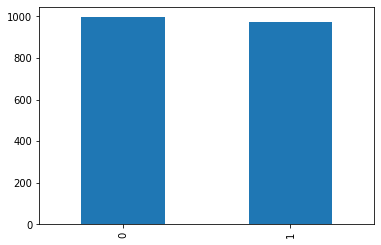

In [137]:
df_main['subreddit'].value_counts().plot(kind = 'bar');

### 2.5 Visualising Popular Words
___

In [118]:
cvec = CountVectorizer()
cvec.fit(df_main['title'])

main = cvec.transform(df_main['title'])

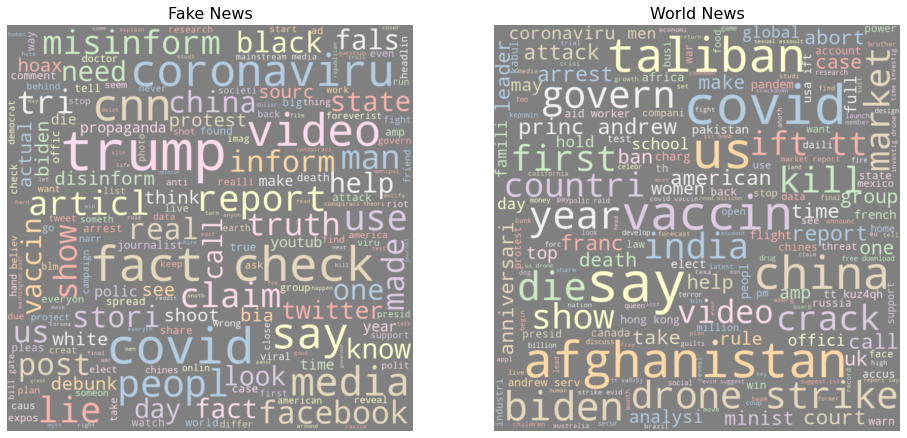

In [149]:
# Word cloud for news

word_fake = ' '.join([word for word in df_main[df_main['subreddit'] == 0]['title']])
word_world = ' '.join([word for word in df_main[df_main['subreddit'] == 1]['title']])

wordcloud_fake = WordCloud(width= 800, 
                      height= 800,
                      max_font_size = 110,
                      collocations = True,
                      background_color = 'grey',
                      colormap= 'Pastel1').generate(word_fake)

wordcloud_world = WordCloud(width= 800, 
                      height= 800,
                      max_font_size = 110,
                      collocations = True,
                      background_color = 'grey',
                      colormap= 'Pastel1').generate(word_world)                      

plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News' , fontsize = 16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_world, interpolation='bilinear')
plt.axis("off")
plt.title('World News' , fontsize = 16);

In [139]:
# Surprisingly I have more vocab after stemming. 4824 compared to 4000.
df_main_vocab = pd.DataFrame(main.todense(),
                             columns = cvec.get_feature_names())
df_main_vocab

,aaj,abandon,abbott,abc,abimael,abl,aboard,abort,abril,absolut,absurd,abuja,abus,academ,academi,acceler,accept,access,accessori,accid,accident,accord,account,accur,accus,achiev,acquit,acronym,across,act,action,activ,activist,actor,actress,actual,acut,ad,adam,add,...,ye,yeadon,yeah,year,yellowknif,yemen,yep,yerə,yet,yevgeni,yhey,yi,yield,yo,yojana,yom,yooooo,york,yoshi,young,youtub,ytbh0y_jthql0javgpvvpg,yuan,za,zakaria,zaprud,zasha,zebra,zeitung,zen,zephyru,zero,zinichev,zombi,zoo,zr2,zubeidi,zucker,zuckerberg,züyünün
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


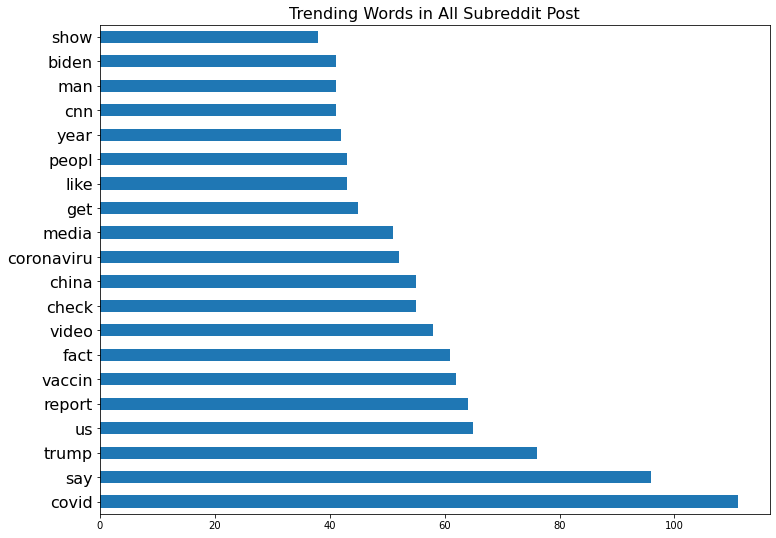

In [164]:
df_main_vocab.sum().sort_values(ascending = False)[:20].plot(kind = 'barh' , figsize = (12,9))
plt.yticks(fontsize = 16)
plt.title('Trending Words in All Subreddit Post' , fontsize = 16);

#3.0 Modelling

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X = df_main['title']
y = df_main['subreddit']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42)

In [170]:
tfidf = TfidfVectorizer()

In [173]:
%%time
rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
                 'min_samples_leaf' : np.arange(1, 5 , 1),
                 'n_estimators' : np.arange(40 , 80 , 10),
                 'max_features' : ['log2' , 'sqrt' , 'auto'],
                 'max_depth' : [None , 3 , 5]}


pipe = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                 ('model', GridSearchCV(estimator = RandomForestClassifier(),
                                        param_grid = rf_param_grid,
                                        cv = 5,
                                        n_jobs=-1))])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
y_pred = model.predict(X_test)

CPU times: user 13.6 s, sys: 715 ms, total: 14.3 s
Wall time: 6min 17s


In [175]:
eval_classification(y_true=y_test , y_pred = y_pred)

{'Accuracy': 0.7868020304568528,
 'F1 Score': 0.8133333333333334,
 'Precision': 0.746938775510204,
 'Recall': 0.8926829268292683}

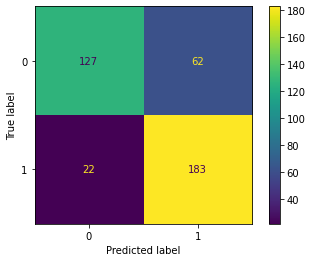

In [181]:
plot_confusion_matrix(model , X_test , y_test , values_format = '.4g');

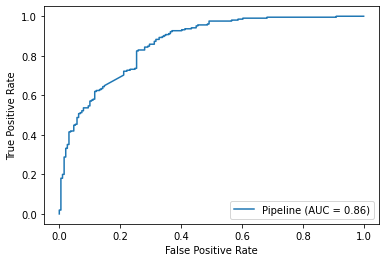

In [183]:
plot_roc_curve(model , X_test , y_test)

# 4.0 Modelling with TF LSTM Bi-directional
___